# Scaling

In this notebook, we train a ResNet model with stretched images to correctly classify with high accuracy whether an image contains an invasive species of hydrangea.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Datasets

We load the Invasive Species Dataset. It assumes the dataset is stored according to format of an ImageFolder dataset.

In [2]:
from torchvision import datasets, models, transforms
import os
from ScaleSquareTransform import ScaleSquare
cwd = os.getcwd()

mean = [0.4249, 0.4764, 0.3832]
std = [0.0819, 0.0810, 0.1059]

data_transforms_original = {
    'train': transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet mean/std
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet mean/std
    ]),
}
data_transforms = {
    'train': transforms.Compose([
        ScaleSquare(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet mean/std
    ]),
    'val': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet mean/std
    ]),
}

data_dir = os.path.join(cwd,"dataset")
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}

dsets_orig = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_original[x])
         for x in ['train', 'val']}
dset_loaders_orig = {x: torch.utils.data.DataLoader(dsets_orig[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print_every = 100
model_save_dir = os.path.join(cwd,"model_params_scaling")


In [85]:
# calculate mean for images
'''
xs = []
num_pixels = 224*224
for t, (x, y) in enumerate(dset_loaders['val']):
    xs.append(x.sum(2).sum(3).squeeze())
for t, (x, y) in enumerate(dset_loaders['train']):
    xs.append(x.sum(2).sum(3).squeeze())

all_xs = torch.cat(xs, 0)/num_pixels
mean = all_xs.mean(0).squeeze()
std = all_xs.std(0).squeeze()

print(mean)
print(std)
'''


 0.4249
 0.4764
 0.3832
[torch.FloatTensor of size 3]


 0.0819
 0.0810
 0.1059
[torch.FloatTensor of size 3]



In [79]:
print(dset_classes)

['0', '1']


## Image sample
Plot an image just to make sure we have something that makes sense.

In [3]:
import torchvision.utils
import matplotlib.pyplot as plt

to_pil = torchvision.transforms.ToPILImage()

def show_img(inp):
    print(inp.size())
    img = to_pil(inp)
    plt.imshow(img)

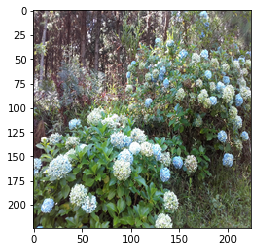

In [108]:
inputs, classes = next(iter(dset_loaders['train']))
show_img(inputs[0])

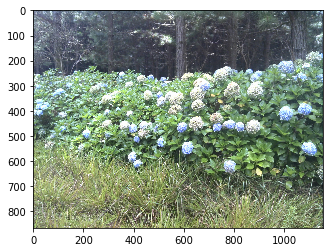

In [109]:
inputs, classes = next(iter(dset_loaders_orig['train']))
show_img(inputs[0])

## Training
We use the following helper function to help us train a model.

In [4]:
def train(model, loss_fn, loader, optimizer, num_epochs = 1, print_every=100):
    loss_history = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            loss_data = loss.data[0]
            loss_history.append(loss_data)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss_data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return loss_history

def check_accuracy(model, loader, return_errors=False, is_testing=False):
    if not is_testing:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    incorrect_x = {0:[],1:[]}
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        if return_errors:
            for i,x_i in enumerate(x):
                if (preds[i]!=y[i])[0] == 1:
                    incorrect_x[preds[i][0]].append(x_i)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, incorrect_x

In [5]:
# Verify that CUDA is properly configured and you have a GPU available
gpu_dtype = torch.cuda.FloatTensor
torch.cuda.is_available()

True

### Tune Hyperparameters
Here we run the learning rate, regularization, and betas for Adam optimizer for 1 epoch.

In [23]:
# tune the hyperparameters

# best acc 0.9703872437357631, beta0 0.95, beta1 0.995, reg 0.0018627520611745705, lr -4.05194392122697

lr_step = 1
lr_range = np.arange(-5,-1,lr_step)
learning_rates = [10**np.random.uniform(n,n+lr_step) for n in lr_range]
reg_step = 1
reg_range = np.arange(-7,-1,reg_step)
regs = [10**np.random.uniform(n,n+reg_step) for n in reg_range]
beta0s = [0.9,0.95]
beta1s = [0.99, 0.995, 0.999]
best_acc = -1
best_beta0 = -1
best_beta1 = -1
best_reg = -1
best_lr = -1

for lr in learning_rates:
    for reg in regs:
        for beta0 in beta0s:
            for beta1 in beta1s:
                model = models.resnet18(pretrained=True)
                num_ftrs = model.fc.in_features
                model.fc = nn.Linear(num_ftrs, 2)
                model.cuda()
                loss_fn = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta0, beta1), weight_decay=reg)
                loss_history = train(model, loss_fn, dset_loaders["train"], optimizer, num_epochs=1)
                acc, _ = check_accuracy(model, dset_loaders["val"])
                if acc > best_acc:
                    best_acc = acc
                    best_beta0 = beta0
                    best_beta1 = beta1
                    best_reg = reg
                    best_lr = lr
                    print("check acc {}, beta0 {}, beta1 {}, reg {}, lr {}".format(acc, beta0, beta1, reg, np.log10(lr)))


print("best acc {}, beta0 {}, beta1 {}, reg {}, lr {}".format(best_acc, best_beta0, best_beta1, best_reg, np.log10(best_lr)))

Starting epoch 1 / 1
t = 100, loss = 0.3571
t = 200, loss = 0.3820
t = 300, loss = 0.0616
t = 400, loss = 0.2567
Checking accuracy on validation set
Got 386 / 439 correct (87.93)
check acc 0.8792710706150342, beta0 0.9, beta1 0.99, reg 1.503364541273813e-07, lr -4.05194392122697
Starting epoch 1 / 1
t = 100, loss = 0.3287
t = 200, loss = 0.3317
t = 300, loss = 0.0814
t = 400, loss = 0.0590
Checking accuracy on validation set
Got 420 / 439 correct (95.67)
check acc 0.9567198177676538, beta0 0.9, beta1 0.995, reg 1.503364541273813e-07, lr -4.05194392122697
Starting epoch 1 / 1
t = 100, loss = 0.2373
t = 200, loss = 0.1299
t = 300, loss = 0.1051
t = 400, loss = 0.2204
Checking accuracy on validation set
Got 415 / 439 correct (94.53)
Starting epoch 1 / 1
t = 100, loss = 1.0730
t = 200, loss = 0.3462
t = 300, loss = 0.0804
t = 400, loss = 0.0408
Checking accuracy on validation set
Got 425 / 439 correct (96.81)
check acc 0.9681093394077449, beta0 0.95, beta1 0.99, reg 1.503364541273813e-07, 

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f31b8ec7d30>>
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f31b8ec7d30>>
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f31b8ec7d30>>
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f31b8ec7d30>>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 218, in __del__
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 218, in __del__
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 218, in __del_

Got 413 / 439 correct (94.08)
Starting epoch 1 / 1


Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f31b8ec7d30>>
Traceback (most recent call last):
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 218, in __del__
    self._shutdown_workers()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 214, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method DataLoade

t = 100, loss = 0.2119
t = 200, loss = 0.9088
t = 300, loss = 0.1020
t = 400, loss = 0.8832
Checking accuracy on validation set
Got 404 / 439 correct (92.03)
Starting epoch 1 / 1
t = 100, loss = 0.6420
t = 200, loss = 0.9917
t = 300, loss = 0.7064
t = 400, loss = 0.6982
Checking accuracy on validation set
Got 179 / 439 correct (40.77)
Starting epoch 1 / 1
t = 100, loss = 0.2552
t = 200, loss = 0.7879
t = 300, loss = 0.7161
t = 400, loss = 0.6930
Checking accuracy on validation set
Got 297 / 439 correct (67.65)
Starting epoch 1 / 1
t = 100, loss = 0.9279
t = 200, loss = 0.9872
t = 300, loss = 0.4450
t = 400, loss = 0.7643
Checking accuracy on validation set
Got 281 / 439 correct (64.01)
Starting epoch 1 / 1
t = 100, loss = 1.3218
t = 200, loss = 1.2764
t = 300, loss = 0.6852
t = 400, loss = 0.4383
Checking accuracy on validation set
Got 277 / 439 correct (63.10)
Starting epoch 1 / 1
t = 100, loss = 0.7264
t = 200, loss = 0.7648
t = 300, loss = 0.6711
t = 400, loss = 0.7285
Checking accu

Process Process-807:
Process Process-808:
Process Process-805:
Process Process-806:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing

KeyboardInterrupt: 

Given the results from the training, we train one model 5 times on the best hyperparameters for 2 epochs and save the results.

In [10]:
# 98.18, 97.27, 95.67, 98.18, 98.18 = 97.40 mAP

# with normalization
# 96.36, 98.41, 93.62, 96.81, 97.49 = 96.53 mAP

# with normalization (from ImageNet means/stds)
# 97.27, 95.22, 94.99, 98.41, 97.49 = 96.67 mAP

# Here we use transfer learning to create a good model based on resnet.
# best acc 0.9703872437357631, beta0 0.95, beta1 0.995, reg 0.0018627520611745705, lr -4.05194392122697
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=10**-4.05194, betas=(0.95, 0.995), weight_decay=0.00186)

loss_history = train(model, loss_fn, dset_loaders["train"], optimizer, num_epochs=2)
acc, incorrects = check_accuracy(model, dset_loaders["val"], True)
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))

Starting epoch 1 / 2
t = 100, loss = 0.1280
t = 200, loss = 0.0518
t = 300, loss = 0.0474
t = 400, loss = 0.0244
Starting epoch 2 / 2
t = 100, loss = 0.2478
t = 200, loss = 0.0342
t = 300, loss = 0.6895
t = 400, loss = 0.0489
Checking accuracy on validation set
Got 428 / 439 correct (97.49)
False negatives: 10
False positives: 1


We can see that stretching the image instead of random cropping and scaling (95.4% mAP) has improved (by ~2.5%) the results (97.4% mAP). This must be because missing, important parts of the image are able to be viewed and factor into the final decision. With normalization, the accuracy decreased.

In [53]:
torch.save(model.state_dict(), model_save_dir)

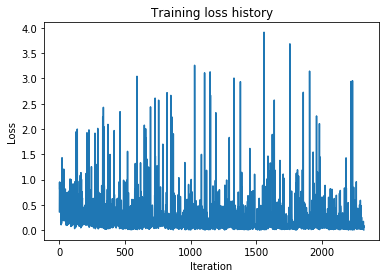

In [27]:
# Plot the training losses
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

The loss here is most likely because it is zoomed it. With the pretrained ResNet, losses start out low, and so we don't get the typical hockey-stick figure. However, the small surges are interesting. Need an explanation here.

## False Positives and False Negatives
Here we plot all of the false positives and false negatives.

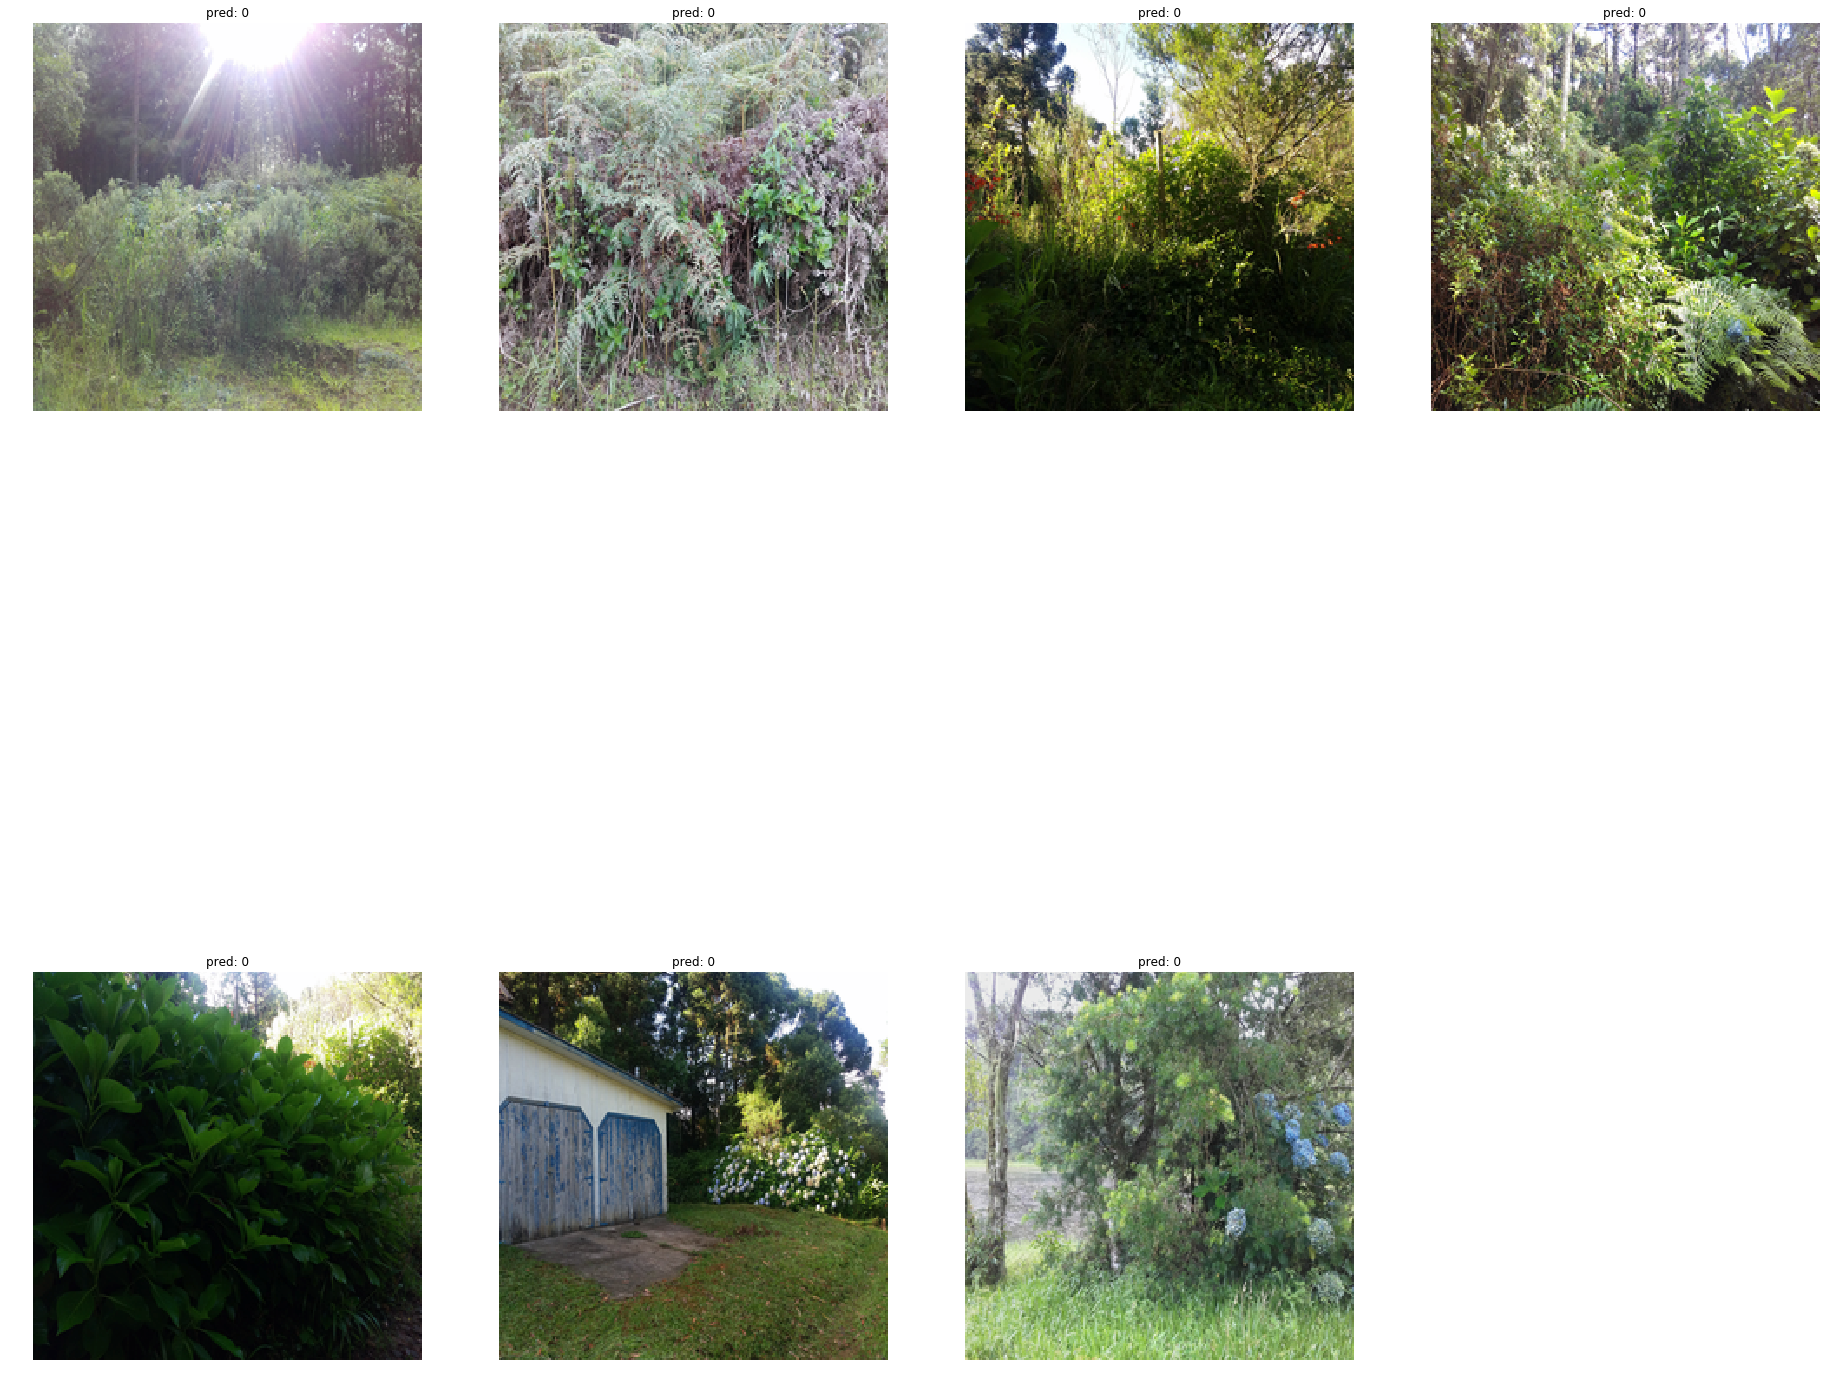

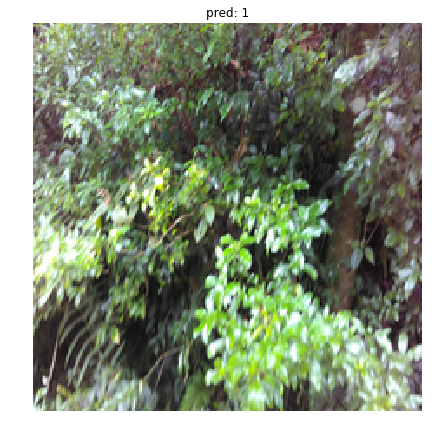

In [121]:
def plot_images(imgs, label):
    num_images = len(imgs)
    fig = plt.figure(figsize=(32, 32)) 
    for j in range(num_images):
        ax = plt.subplot(num_images//4+1, 4, j+1)
        ax.axis('off')
        ax.set_title('pred: {}'.format(label))
        show_img(imgs[j])

plot_images(incorrects[0], "0")
plot_images(incorrects[1], "1")

## Saliency Maps
Let's now take a look at the saliency maps for the false positives and false negatives. (Thank you assignment 3!)

In [111]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X.type(gpu_dtype), requires_grad=True)
    y_var = Variable(y)
    saliency = None
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
    scores = model(X_var)
    loss = loss_fn(scores, y_var)
    loss.backward()
    saliency = X_var.grad.data.abs().max(dim=1)[0].squeeze()
    return saliency

In [117]:
def show_saliency_maps(X, y, name):
    to_pil = torchvision.transforms.ToPILImage()
    X_tensor = torch.cat([x.unsqueeze(0) for x in X], 0)
    y_tensor = y#torch.cuda.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    N = X_tensor.size()[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        show_img(X_tensor[i])
        plt.axis('off')
        plt.title(name)
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

### False positives saliency maps

TypeError: Invalid dimensions for image data

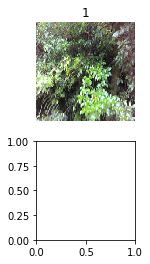

In [122]:
false_positives = incorrects[1]
show_saliency_maps(false_positives, torch.zeros(len(false_positives)).type(torch.cuda.LongTensor), '1')

### False negatives saliency maps

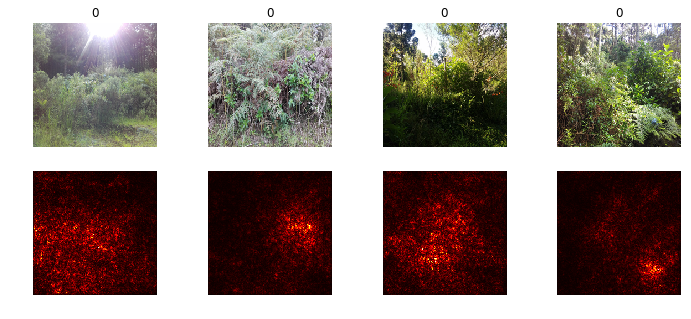

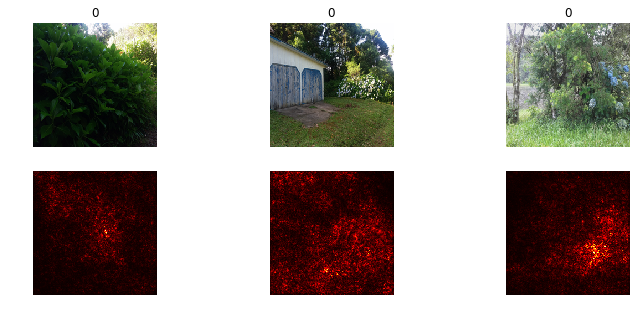

In [123]:
false_negatives = incorrects[0][0:4]
show_saliency_maps(false_negatives, torch.zeros(len(false_negatives)).type(torch.cuda.LongTensor), '0')
false_negatives = incorrects[0][4:8]
show_saliency_maps(false_negatives, torch.zeros(len(false_negatives)).type(torch.cuda.LongTensor), '0')
#false_negatives = incorrects[0][8:13]
#show_saliency_maps(false_negatives, torch.zeros(len(false_negatives)).type(torch.cuda.LongTensor), '0')

## Image processing
From the saliency maps above, we can see that images are misclassified in the false positive case because the similar leaves that are highlighted in the map might be triggering the classification. For the false negative case, which has many more instances than in the false positive, we can see that some of the misclassifications are a scaling issue, where the images are too far in the background. In other cases, the hydrangeas are being choked by weeds, and so they aren't completely surrounded by their own leaves. However, it is interesting that the maps show that the classifier still correctly identifies where the hydrangeas are, even if the last layer classifies the image as a false.

For the false negative case, we can try to chop up the images into equally-sized squares and do a model-ensemble-like scoring where we combine the scores from the various sections of the image. The scoring would be such that an image section that returns a high probability would carry more weight than one of a medium probability. However, this is very similar to what SSD is trying to accomplish, so instead that is tried here.